# Transfer Learning - EfficientNetB7 Model


- Alzhemimer's Disease Neuroimaging Initiative (ADNI) dataset
- Three classes:
    - Normal control
    - Mild cognitive impairment
    - Alzheimer's disease
- 6 hospitals

In [1]:
import numpy as np
import tensorflow as tf
import os
import nibabel as nib
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB7

In [2]:
# Utility functions
def zoom_out(image, width=128, height=128):
    new_img = zoom(image, (width / image.shape[0], height / image.shape[1],1))
    return new_img

def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    if scan.ndim == 3:
        scan = scan[:,:,:,np.newaxis]
    return scan

def normalize(volume):
    volume = 255*(volume - volume.min()) / (volume.max() - volume.min())
    volume = volume.astype("float32")
    return volume

def process_scan(path,nslices, H, W):
    volume = read_nifti_file(path)
    volume = np.concatenate((volume[:-2],volume[1:-1], volume[2:]), axis = -1)
    #X1, X2, X3, 1 -> (X1-2), X2, X3, 3
    volume_slices = np.zeros((nslices,H,W,volume.shape[3]),dtype = np.float32)
    #print(range(int(volume.shape[0] / 2 - nslices/2),int(volume.shape[0] / 2 + nslices/2)))
    for (ii,jj) in enumerate(range(int(volume.shape[0] / 2 - nslices/2),int(volume.shape[0] / 2 + nslices/2))): 
        volume_slices[ii] = zoom_out(volume[jj], H, W)
    volume_slices = normalize(volume_slices)
    return volume_slices

In [3]:
# Listing AD, NC, and MCI subjects/volumes
root = 'C:\\Users\\amin\\Downloads\\adni data and code\\ADNI\\AD'
ad_paths = []
for path, subdirs, files in os.walk(root):
    aux = path
    for name in files:
        if '.nii' in name:
            if name[0] != '.':
                ad_paths.append(aux + '/' + name)

root = 'C:\\Users\\amin\\Downloads\\adni data and code\\ADNI\\CN'
nc_paths = []
for path, subdirs, files in os.walk(root):
    aux = path
    for name in files:
        if '.nii' in name:
            if name[0] != '.':
                nc_paths.append(aux + '/' + name)
                
root = 'C:\\Users\\amin\\Downloads\\adni data and code\\ADNI\\MCI'
mci_paths = []
for path, subdirs, files in os.walk(root):
    aux = path
    for name in files:
        if '.nii' in name:
            if name[0] != '.':
                mci_paths.append(aux + '/' + name)
print(len(ad_paths))       
print(len(nc_paths)) 
print(len(mci_paths))

594
1131
857


In [4]:
nslices = 1 # Slices per volume to extract
H, W = 128,128 # Resize dimensions
class_names = ["AD", "NC", "MCI"]

all_paths = ad_paths + nc_paths #+ mci_paths # All files combined
y_subjects = [0]*len(ad_paths) + [1]*len(nc_paths) #+ [2]*len(mci_paths) # Labels for the volumes

In [5]:
# Split train/val/test sets
paths_train, paths_test, y_subjects_train, y_subjects_test = \
train_test_split(all_paths, y_subjects,test_size=0.2, random_state=0,stratify =y_subjects)

paths_train, paths_val, y_subjects_train, y_subjects_val = \
train_test_split(paths_train, y_subjects_train, test_size=0.2, random_state=0,stratify =y_subjects_train)


In [6]:
import re
from collections import defaultdict

def get_hospitals_list(paths):
    return list(map(lambda s: re.findall('[^_]+_\\d+', re.findall('ADNI\\\\\\w+\\\\[^\\\\]*', s)[0].split('\\')[-1])[0], paths))

hospitals = np.unique(get_hospitals_list(all_paths))

def create_hospital_dict(paths):
    dict = defaultdict(list)
    for i, h in enumerate(get_hospitals_list(paths)):
        dict[h].append(i)
    return dict



In [7]:
X_train = np.zeros((nslices*len(paths_train),H,W,3), dtype = np.float32)
Y_train = np.repeat(y_subjects_train,nslices)

counter = 0
for img_file in paths_train:
    temp_img = process_scan(img_file,nslices, H, W)
    X_train[counter*nslices:(counter+1)*nslices] = temp_img
    counter+=1

train_dict = create_hospital_dict(paths_train)
for hospital in hospitals:
    path = './dataset/' + hospital + '/'
    os.makedirs(path, exist_ok=True)
    np.save(path + 'x_train.npy', X_train[train_dict[hospital]])
    np.save(path + 'y_train.npy', Y_train[train_dict[hospital]])

In [8]:
X_val = np.zeros((nslices*len(paths_val),H,W,3), dtype = np.float32)
Y_val = np.repeat(y_subjects_val,nslices)

counter = 0
for img_file in paths_val:
    temp_img = process_scan(img_file,nslices, H, W)
    X_val[counter*nslices:(counter+1)*nslices] = temp_img
    counter+=1

np.save('./dataset/x_val.npy', X_val)
np.save('./dataset/y_val.npy', Y_val)

In [9]:
X_test = np.zeros((nslices*len(paths_test),H,W,3), dtype = np.float32)
Y_test = np.repeat(y_subjects_test,nslices)

counter = 0
for img_file in paths_test:
    temp_img = process_scan(img_file,nslices, H, W)
    X_test[counter*nslices:(counter+1)*nslices] = temp_img
    counter+=1
print(X_test.min(),X_test.max())

np.save('./dataset/x_test.npy', X_test)
np.save('./dataset/y_test.npy', Y_test)

0.0 255.00002


In [10]:
# One-hot encoding
Y_train_oh = tf.keras.utils.to_categorical(Y_train, 2)
Y_val_oh = tf.keras.utils.to_categorical(Y_val, 2)
Y_test_oh = tf.keras.utils.to_categorical(Y_test, 2)

In [11]:
print(X_val.min(),X_val.max())

0.0 255.00002


In [12]:
model_name = "efficientnet_adni.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [13]:
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":5,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.1, "horizontal_flip":True,"vertical_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size) 

38.191566 36.78449
0.0 248.72021


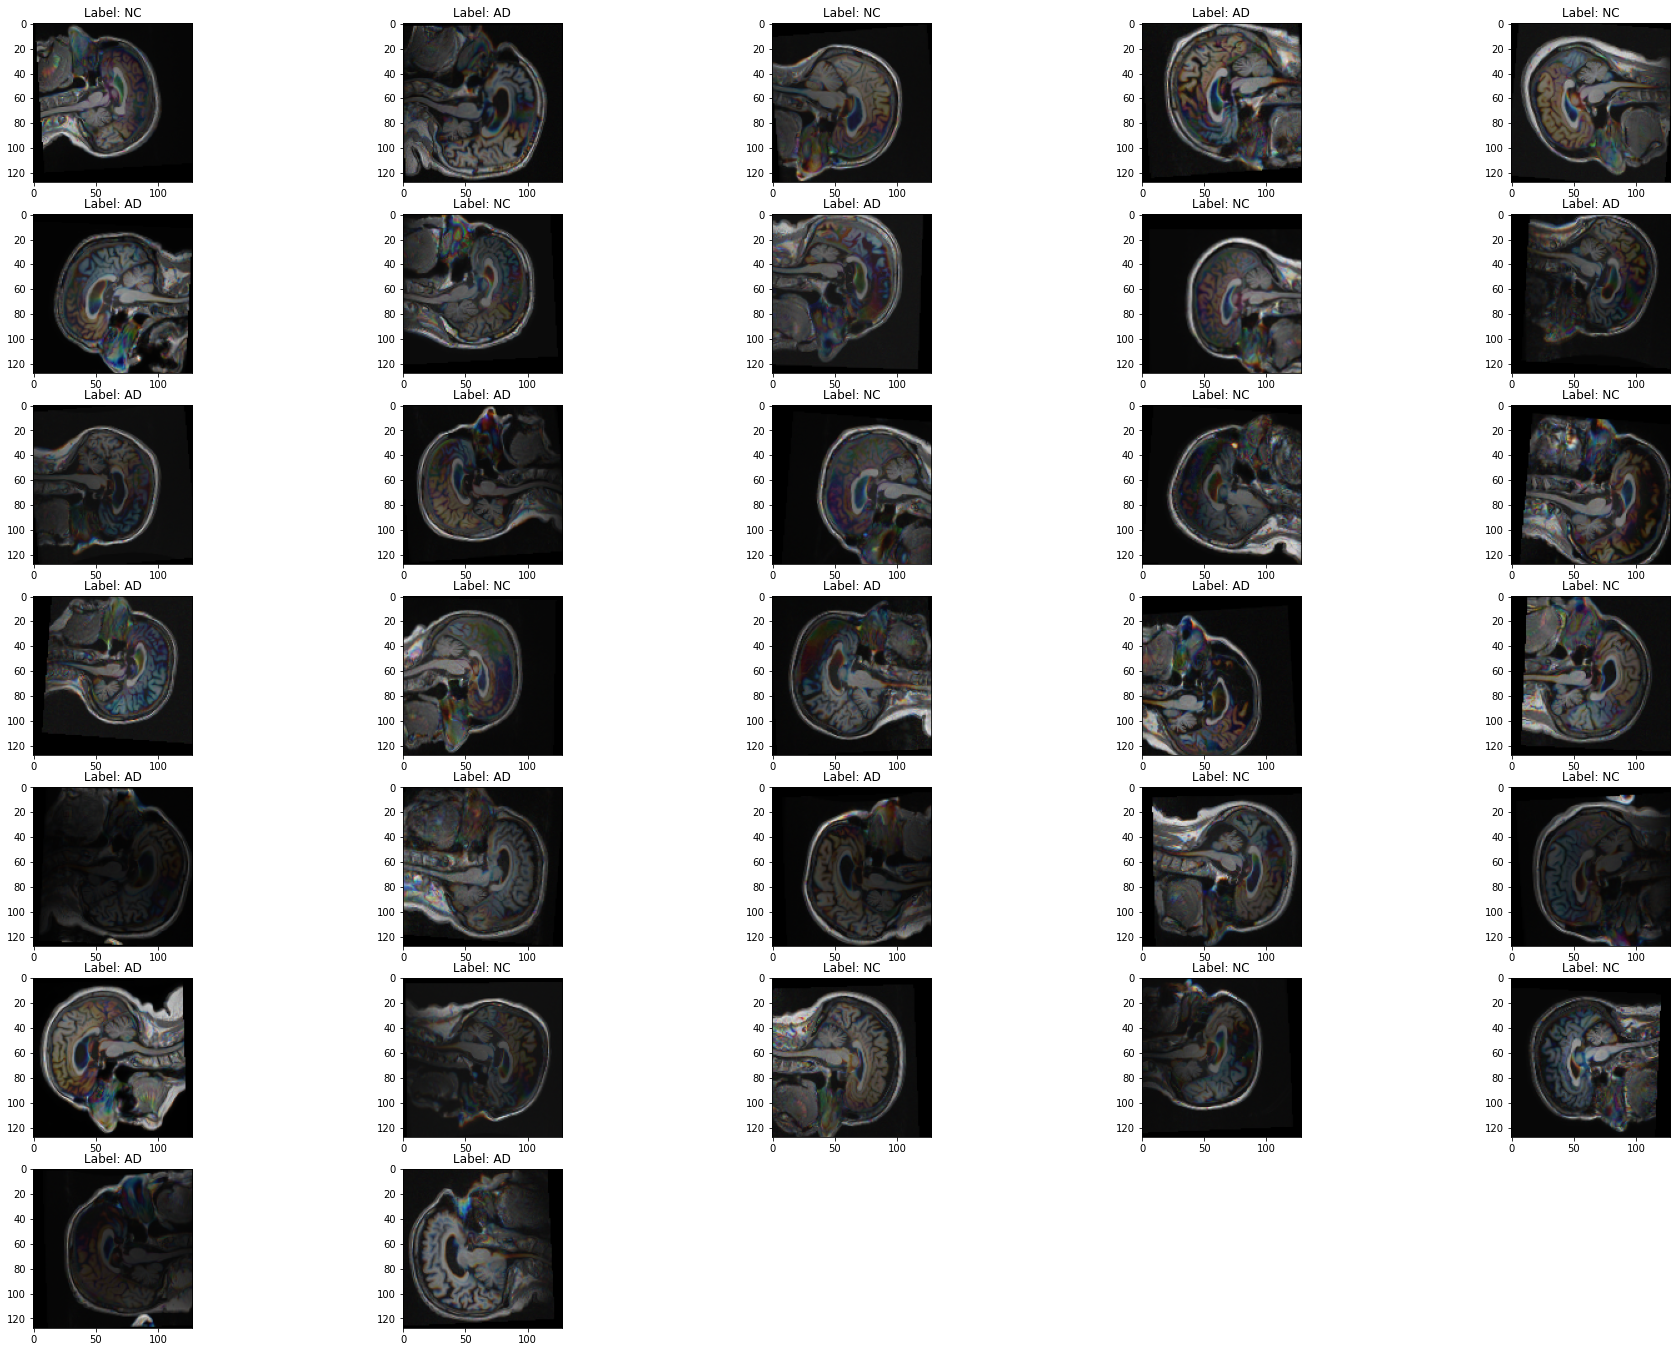

In [14]:
# Disaplying some samples from the development set
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow(Xbatch[ii]/255, cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

In [15]:
model = EfficientNetB7(include_top=False,weights='imagenet', input_shape=(128,128,3))

model.trainable = False
# add new classifier layers
x1 = model(model.inputs, training = False)

flat1 = tf.keras.layers.Flatten()(x1)
output = tf.keras.layers.Dense(2, activation='softmax')(flat1)
# define new model
model = tf.keras.Model(inputs=model.inputs, outputs=output)
# summarize
model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])



history = model.fit(train_flow,\
                    epochs=150,
                    verbose=1,
                    validation_data = val_flow,callbacks = [early_stop,monitor,lr_schedule],shuffle = True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 4, 4, 2560)        64097687  
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 81922     
Total params: 64,179,609
Trainable params: 81,922
Non-trainable params: 64,097,687
_________________________________________________________________
Epoch 1/150
35/35 [==============================] - 23s 243ms/step - loss: 0.6617 - accuracy: 0.6359 - val_loss: 0.6211 - val_accuracy: 0.6703

C:\PycharmProjects\alo\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
